In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import kmeans_plusplus
from scipy.io import savemat, loadmat
import scipy.io as sio


In [2]:
# ------------------------------------------------
# 1. Dataset configuration
# ------------------------------------------------
# NOTE: Update feature_cols per dataset to match your CSV schema.

DATASET_CONFIG = {
    "adult": {
        "csv_path": "adult_balance_v2.csv",
        "feature_cols": [
            "age", "final-weight", "education-num", "marital-status",
            "occupation", "relationship", "capital-gain",
            "hours-per-week", "native-country", "income"
        ],
        "sensitive_col": "sex",
        "k": 6,
        "tag": "adult",   # used in file names
    },
    "bank": {
        "csv_path": "bank_violating_labeled_5.csv",
        "feature_cols": [
            # TODO: replace with the actual columns you use for Bank
            "age", "job", "marital", "education", "balance",
            "housing", "loan", "campaign", "pdays", "previous"
        ],
        "sensitive_col": "sex",   # or the actual protected attribute
        "k": 6,
        "tag": "bank",
    },
    "credit": {
        "csv_path": "credit_violating_labeled_5.csv",
        "feature_cols": [
            # TODO: replace with the actual columns you use for Credit
            "LIMIT_BAL", "AGE", "PAY_0", "PAY_2", "PAY_3",
            "PAY_4", "PAY_5", "PAY_6", "BILL_AMT1", "BILL_AMT2"
        ],
        "sensitive_col": "sex",
        "k": 6,
        "tag": "credit",
    },
    "student": {
        "csv_path": "student_violating_labeled_5.csv",
        "feature_cols": [
            # TODO: replace with the actual columns you use for Student
            "age", "Medu", "Fedu", "studytime", "failures",
            "famrel", "freetime", "goout", "G1", "G2"
        ],
        "sensitive_col": "sex",
        "k": 6,
        "tag": "student",
    },
}


In [3]:
# ------------------------------------------------
# 2. Utility functions
# ------------------------------------------------

def load_dataset(dataset_name: str):
    """Load and standardize the dataset, and build sensitive group masks."""
    cfg = DATASET_CONFIG[dataset_name]
    df = pd.read_csv(cfg["csv_path"])
    X = df[cfg["feature_cols"]].values
    s = df[cfg["sensitive_col"]].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # We assume sensitive attribute is binary and >0 means group A
    A_mask = (s > 0)
    B_mask = ~A_mask

    print(f"[{dataset_name}] n = {len(X_scaled)}")
    print(f"[{dataset_name}] |A| = {A_mask.sum()}, |B| = {B_mask.sum()}")
    assert A_mask.sum() + B_mask.sum() == len(X_scaled)

    return X_scaled, A_mask, B_mask, cfg


def assign_points(X, C):
    """Assign each point in X to its closest center in C."""
    d2 = ((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)
    return d2.argmin(axis=1)


def kmeans_loss(X, C, a):
    """Standard k-means loss (mean squared distance to assigned centers)."""
    return ((X - C[a]) ** 2).sum() / len(X)


def delta_group(X, C, a, group_mask):
    """Sum of squared distances for points in one demographic group."""
    idx = np.where(group_mask)[0]
    if len(idx) == 0:
        return 0.0
    return ((X[idx] - C[a[idx]]) ** 2).sum()


def phi_max(X, C, a, A_mask, B_mask):
    """
    Compute average distance for each group and return:
    (worst_group_cost, 'A' or 'B').
    """
    nA = A_mask.sum()
    nB = B_mask.sum()
    if nA == 0 or nB == 0:
        raise ValueError("Both groups must be present.")

    dA = delta_group(X, C, a, A_mask) / nA
    dB = delta_group(X, C, a, B_mask) / nB
    if dA >= dB:
        return dA, "A"
    else:
        return dB, "B"


def grad_centers(X, C, a, A_mask, B_mask, lam):
    """
    Gradient of the Social Fair k-means objective with respect to centers.
    Includes:
      - standard k-means gradient
      - plus λ * fairness gradient for the worst-off group.
    """
    n = len(X)
    k, d = C.shape

    Gk = np.zeros_like(C)      # k-means gradient
    Gfair = np.zeros_like(C)   # fairness gradient

    # --- k-means gradient ---
    for j in range(k):
        idx = np.where(a == j)[0]
        if idx.size == 0:
            continue
        diff = C[j] - X[idx]          # (#idx, d)
        Gk[j] = (2.0 / n) * diff.sum(axis=0)

    # --- fairness gradient ---
    if lam != 0.0:
        _, branch = phi_max(X, C, a, A_mask, B_mask)

        if branch == "A":
            Ng = int(A_mask.sum())
            if Ng > 0:
                for j in range(k):
                    idx = np.where((a == j) & A_mask)[0]
                    if idx.size == 0:
                        continue
                    diff = C[j] - X[idx]
                    Gfair[j] += (2.0 / Ng) * diff.sum(axis=0)
        else:
            Ng = int(B_mask.sum())
            if Ng > 0:
                for j in range(k):
                    idx = np.where((a == j) & B_mask)[0]
                    if idx.size == 0:
                        continue
                    diff = C[j] - X[idx]
                    Gfair[j] += (2.0 / Ng) * diff.sum(axis=0)

    return Gk + lam * Gfair


def update_centroids_analytic(X, a, k, C_prev):
    """Standard Lloyd centroid update, keeping empty clusters unchanged."""
    C_new = C_prev.copy()
    for j in range(k):
        idx = np.where(a == j)[0]
        if idx.size > 0:
            C_new[j] = X[idx].mean(axis=0)
        else:
            # Keep the old center if the cluster is empty
            C_new[j] = C_prev[j]
    return C_new


def train_fair_kmeans(X, A_mask, B_mask, C0, lam=1.0,
                      iters=500, inner_gd=5, lr=0.05):
    """
    Social Fair k-means training.

    If lam = 0, this reduces to standard Lloyd's algorithm.
    Otherwise, we alternate between hard assignments and several
    gradient-descent steps on the centers.
    """
    C = C0.copy()
    history = []
    k = C.shape[0]
    use_lloyd = (lam <= 1e-12)

    for t in range(iters):
        # (a) hard assignments
        a = assign_points(X, C)

        if use_lloyd:
            C = update_centroids_analytic(X, a, k, C)
        else:
            for _ in range(inner_gd):
                G = grad_centers(X, C, a, A_mask, B_mask, lam)
                C = C - lr * G

        km = kmeans_loss(X, C, a)
        if not use_lloyd:
            phi_val, _ = phi_max(X, C, a, A_mask, B_mask)
        else:
            phi_val = 0.0
        history.append({"iter": t, "kmeans_loss": km, "phi": phi_val})

    return C, history

In [4]:
def compute_pairwise_fairness(X, XA, XB, centroids):
    """
    Separation-style fairness (counterfactual hyperplane distance),
    kept here only as an additional diagnostic.
    """
    def get_squared_distance_to_hyperplane(x, m1, m2):
        m = 0.5 * (m1 + m2)
        v = m2 - m1
        v = v / np.linalg.norm(v)
        return ((x - m) @ v) ** 2

    fairness_A = []
    fairness_B = []
    for x in XA:
        dists = np.linalg.norm(centroids - x, axis=1)
        m1_idx = np.argmin(dists)
        m1 = centroids[m1_idx]
        dists[m1_idx] = np.inf
        m2 = centroids[np.argmin(dists)]
        fairness_A.append(get_squared_distance_to_hyperplane(x, m1, m2))

    for x in XB:
        dists = np.linalg.norm(centroids - x, axis=1)
        m1_idx = np.argmin(dists)
        m1 = centroids[m1_idx]
        dists[m1_idx] = np.inf
        m2 = centroids[np.argmin(dists)]
        fairness_B.append(get_squared_distance_to_hyperplane(x, m1, m2))

    mu_A = np.mean(fairness_A)
    mu_B = np.mean(fairness_B)
    return mu_A, mu_B, min(mu_A, mu_B)

In [5]:
def run_unfair_lloyd(X, C0, iters=200, tol=1e-10):
    """Run standard (unfair) Lloyd k-means starting from centers C0."""
    C = C0.copy()
    for _ in range(iters):
        a = assign_points(X, C)
        C_new = update_centroids_analytic(X, a, C.shape[0], C)
        if np.linalg.norm(C_new - C) < tol:
            C = C_new
            break
        C = C_new
    return C

In [6]:
# ------------------------------------------------
# 3. Main Social Fair training loop
# ------------------------------------------------

def run_social_fair_kmeans_pipeline(dataset_name: str,
                                    lambda2_list=None,
                                    seeds=None,
                                    iters_fair=500,
                                    inner_gd=5,
                                    lr=0.5):
    """
    Train Social Fair k-means on the chosen dataset for a list of λ values
    and random seeds.

    Returns:
        metrics: dict with entries:
          - 'max_fair_dict'
          - 'fairness_gaps'
          - 'kmeans_costs'
          - 'unfair_kmeans_costs'
          - 'min_fair_dict'
        cfg: dataset configuration
    """
    if lambda2_list is None:
        lambda2_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    if seeds is None:
        seeds = list(range(10))

    X_input, A_mask, B_mask, cfg = load_dataset(dataset_name)
    k = cfg["k"]
    tag = cfg["tag"]

    # Metric containers
    max_fair_dict_lambda2 = {lam: [] for lam in lambda2_list}
    fairness_gaps_lambda2 = {lam: [] for lam in lambda2_list}
    kmeans_costs_lambda2 = {lam: [] for lam in lambda2_list}
    unfair_kmeans_costs_lambda2 = {lam: [] for lam in lambda2_list}
    min_fair_dict_lambda2 = {lam: [] for lam in lambda2_list}

    # Directories for saving
    root = Path(".")
    init_dir = root / "init_centers_mat"
    fair_dir = root / "clustering_file_with_seed" / "fair"
    unfair_dir = root / "clustering_file_with_seed" / "unfair"
    for d in [init_dir, fair_dir, unfair_dir]:
        d.mkdir(parents=True, exist_ok=True)

    # Main loop over seeds
    for seed in seeds:
        print(f"\n=== Dataset: {dataset_name}, seed = {seed} ===")
        # Initialization (same for all λ for this seed)
        init_centers, _ = kmeans_plusplus(X_input, n_clusters=k,
                                          random_state=seed)
        savemat(
            (init_dir / f"init_centers_seed{seed}_{tag}.mat").as_posix(),
            {
                "init_centers": init_centers.astype(np.float64),
                "seed": int(seed),
                "k": int(k),
                "d": int(X_input.shape[1]),
            },
            do_compression=True,
        )

        # Unfair baseline: Lloyd
        C_unfair = run_unfair_lloyd(X_input, init_centers.copy())
        a_unfair = assign_points(X_input, C_unfair)
        km_unfair = kmeans_loss(X_input, C_unfair, a_unfair)

        labels_unfair_1based = (a_unfair.astype(np.int32) + 1)
        savemat(
            (
                unfair_dir
                / f"clustering_{tag}_seed_{seed}_lambda_0.0.mat"
            ).as_posix(),
            {
                "female_labels": labels_unfair_1based[B_mask],
                "male_labels": labels_unfair_1based[A_mask],
                "labels_all": labels_unfair_1based,
                "lambda2": 0.0,
                "seed": int(seed),
                "k": int(k),
            },
            do_compression=True,
        )

        XA = X_input[A_mask]
        XB = X_input[B_mask]

        # Loop over fairness weights λ
        for lam2 in lambda2_list:
            unfair_kmeans_costs_lambda2[lam2].append(km_unfair)

            if lam2 == 0.0:
                C_final = C_unfair.copy()
                a_final = a_unfair.copy()
                km_fair = km_unfair
            else:
                C_final, _ = train_fair_kmeans(
                    X_input,
                    A_mask,
                    B_mask,
                    C0=init_centers.copy(),
                    lam=lam2,
                    iters=iters_fair,
                    inner_gd=inner_gd,
                    lr=lr,
                )
                a_final = assign_points(X_input, C_final)
                km_fair = kmeans_loss(X_input, C_final, a_final)

            # Social fairness metrics
            valA = ((X_input[A_mask] - C_final[a_final[A_mask]]) ** 2).sum() / A_mask.sum()
            valB = ((X_input[B_mask] - C_final[a_final[B_mask]]) ** 2).sum() / B_mask.sum()
            max_fair = max(valA, valB)
            diff_abs = abs(valA - valB)

            # Separation-style fairness (optional)
            mu_A_sep, mu_B_sep, min_fair = compute_pairwise_fairness(
                X_input, XA, XB, C_final
            )

            kmeans_costs_lambda2[lam2].append(km_fair)
            max_fair_dict_lambda2[lam2].append(max_fair)
            fairness_gaps_lambda2[lam2].append(diff_abs)
            min_fair_dict_lambda2[lam2].append(min_fair)

            labels_fair_1based = (a_final.astype(np.int32) + 1)
            savemat(
                (
                    fair_dir
                    / f"clustering_{tag}_seed_{seed}_(1-lambda)_{lam2:.1f}.mat"
                ).as_posix(),
                {
                    "female_labels": labels_fair_1based[B_mask],
                    "male_labels": labels_fair_1based[A_mask],
                    "labels_all": labels_fair_1based,
                    "lambda2": float(lam2),
                    "seed": int(seed),
                    "k": int(k),
                },
                do_compression=True,
            )

    # Print summary
    for lam2 in lambda2_list:
        print(
            f"λ={lam2:.1f} | "
            f"km_unfair(mean)={np.mean(unfair_kmeans_costs_lambda2[lam2]):.6f} | "
            f"km_fair(mean)={np.mean(kmeans_costs_lambda2[lam2]):.6f} | "
            f"gap(mean)={np.mean(fairness_gaps_lambda2[lam2]):.6f} | "
            f"min_fair(mean)={np.mean(min_fair_dict_lambda2[lam2]):.6f}"
        )

    metrics = {
        "max_fair_dict": max_fair_dict_lambda2,
        "fairness_gaps": fairness_gaps_lambda2,
        "kmeans_costs": kmeans_costs_lambda2,
        "unfair_kmeans_costs": unfair_kmeans_costs_lambda2,
        "min_fair_dict": min_fair_dict_lambda2,
    }
    return metrics, cfg, lambda2_list


In [7]:
# ------------------------------------------------
# 4. Load Fair-Lloyd .mat results (optional, if you have them)
# ------------------------------------------------

def load_fair_lloyd_stats(dataset_tag, lambda2_list, seeds):
    """
    Load Fair-Lloyd results from MATLAB .mat files, if available.
    Expects files in: cost_seeds/full_results_seed_{seed}_lambda_{lam}_{tag}.mat

    Returns:
      stats dict OR None if no files were found.
    """
    def f(x):
        return float(np.asarray(x).squeeze())

    n_lam = len(lambda2_list)
    n_seeds = len(seeds)

    costs_unfair_F = np.zeros((n_lam, n_seeds))
    costs_unfair_M = np.zeros((n_lam, n_seeds))
    costs_social_F = np.zeros((n_lam, n_seeds))
    costs_social_M = np.zeros((n_lam, n_seeds))

    unfair_diff = np.zeros((n_lam, n_seeds))
    fair_diff = np.zeros((n_lam, n_seeds))

    k_means_loss_unfair = np.zeros((n_lam, n_seeds))
    k_means_loss_fair = np.zeros((n_lam, n_seeds))

    maxfair_unfair = np.full((n_lam, n_seeds), np.nan)
    maxfair_fair = np.full((n_lam, n_seeds), np.nan)

    any_found = False

    for i, lam in enumerate(lambda2_list):
        lam_str = f"{lam:.1f}"
        for j, seed in enumerate(seeds):
            result_path = f"cost_seeds/full_results_seed_{seed}_lambda_{lam_str}_{dataset_tag}.mat"
            if not os.path.exists(result_path):
                # you can uncomment if you want to see missing files:
                # print(f"[Fair-Lloyd] Missing: seed={seed}, λ={lam_str}")
                continue

            any_found = True
            cost = sio.loadmat(result_path)

            costs_unfair_F[i, j] = f(cost["costUnfair"][0][0])
            costs_unfair_M[i, j] = f(cost["costUnfair"][1][0])
            costs_social_F[i, j] = f(cost["costFair"][0][0])
            costs_social_M[i, j] = f(cost["costFair"][1][0])

            unfair_diff[i, j] = abs(costs_unfair_F[i, j] - costs_unfair_M[i, j])
            fair_diff[i, j] = abs(costs_social_F[i, j] - costs_social_M[i, j])

            k_means_loss_unfair[i, j] = f(cost["kmUnfair"])
            k_means_loss_fair[i, j] = f(cost["kmFair"])

            if all(k in cost for k in ("kmUnfairG1", "kmUnfairG2", "kmFairG1", "kmFairG2")):
                maxfair_unfair[i, j] = max(f(cost["kmUnfairG1"]), f(cost["kmUnfairG2"]))
                maxfair_fair[i, j] = max(f(cost["kmFairG1"]), f(cost["kmFairG2"]))

    if not any_found:
        print("[Fair-Lloyd] No .mat results found – skipping Fair-Lloyd curves.")
        return None

    stats = {
        "unfair_diff": unfair_diff,
        "fair_diff": fair_diff,
        "k_means_loss_unfair": k_means_loss_unfair,
        "k_means_loss_fair": k_means_loss_fair,
        "maxfair_unfair": maxfair_unfair,
        "maxfair_fair": maxfair_fair,
    }
    return stats


In [8]:
def plot_social_metrics(metrics, lambda2_list, cfg,
                        fair_lloyd_stats=None, save_path="./plots"):
    """
    Plot:
      - Max Fair
      - Fairness Difference
      - Minimum Separation Fairness (optional)
      - K-means Loss

    If fair_lloyd_stats is provided, includes Unfair K-means and
    Fair-Lloyd baselines in the plots.
    """
    Path(save_path).mkdir(parents=True, exist_ok=True)
    tag = cfg["tag"]

    max_fair_dict = metrics["max_fair_dict"]
    fairness_gaps_dict = metrics["fairness_gaps"]
    kmeans_costs_dict = metrics["kmeans_costs"]
    min_fair_dict = metrics["min_fair_dict"]

    def get_mean_std(d):
        means = [np.mean(d[l]) for l in lambda2_list]
        stds = [np.std(d[l]) for l in lambda2_list]
        return np.array(means), np.array(stds)

    def lam_label(l):
        s = f"{l:.2f}".rstrip("0").rstrip(".")
        return r"$\lambda$=" + s

    max_fair_mean, max_fair_std = get_mean_std(max_fair_dict)
    gap_mean, gap_std = get_mean_std(fairness_gaps_dict)
    cost_mean, cost_std = get_mean_std(kmeans_costs_dict)
    min_fair_mean, min_fair_std = get_mean_std(min_fair_dict)

    social_lams = list(lambda2_list)
    x_social = np.arange(1, 1 + len(social_lams))
    tick_pos = x_social
    tick_labels = [lam_label(l) for l in social_lams]

    # ---- If Fair-Lloyd stats exist, precompute their summaries ----
    if fair_lloyd_stats is not None:
        unfair_diff = fair_lloyd_stats["unfair_diff"]
        fair_diff = fair_lloyd_stats["fair_diff"]
        km_unfair = fair_lloyd_stats["k_means_loss_unfair"]
        km_fair = fair_lloyd_stats["k_means_loss_fair"]
        max_unfair = fair_lloyd_stats["maxfair_unfair"]
        max_fair = fair_lloyd_stats["maxfair_fair"]

        idx0 = 0
        idx1 = len(lambda2_list) - 1

        mu_unfair_maxfair = np.nanmean(max_unfair[idx0, :])
        sd_unfair_maxfair = np.nanstd(max_unfair[idx0, :], ddof=1)
        mu_fair_maxfair = np.nanmean(max_fair[idx1, :])
        sd_fair_maxfair = np.nanstd(max_fair[idx1, :], ddof=1)

        mu_unfair_gap = np.nanmean(unfair_diff[idx0, :])
        sd_unfair_gap = np.nanstd(unfair_diff[idx0, :], ddof=1)
        mu_fair_gap = np.nanmean(fair_diff[idx1, :])
        sd_fair_gap = np.nanstd(fair_diff[idx1, :], ddof=1)

        mu_unfair_loss = np.nanmean(km_unfair[idx0, :])
        sd_unfair_loss = np.nanstd(km_unfair[idx0, :], ddof=1)
        mu_fair_loss = np.nanmean(km_fair[idx1, :])
        sd_fair_loss = np.nanstd(km_fair[idx1, :], ddof=1)
    else:
        mu_unfair_maxfair = sd_unfair_maxfair = None
        mu_fair_maxfair = sd_fair_maxfair = None
        mu_unfair_gap = sd_unfair_gap = None
        mu_fair_gap = sd_fair_gap = None
        mu_unfair_loss = sd_unfair_loss = None
        mu_fair_loss = sd_fair_loss = None

    # ---------------- Max Fair ----------------
    plt.figure(figsize=(6, 5))
    plt.errorbar(
        x_social, max_fair_mean, yerr=max_fair_std,
        fmt="-o", capsize=4, linewidth=3, color="tab:purple",
        label="Social Fair k-means"
    )

    if mu_unfair_maxfair is not None:
        x_unfair = np.array([0])
        x_fair = np.array([x_social[-1] + 1])
        plt.errorbar(
            x_unfair, [mu_unfair_maxfair], yerr=[sd_unfair_maxfair],
            fmt="o", capsize=5, linewidth=3, label="Unfair k-means"
        )
        plt.errorbar(
            x_fair, [mu_fair_maxfair], yerr=[sd_fair_maxfair],
            fmt="o", capsize=5, linewidth=3, label="Fair-Lloyd"
        )
        plt.xlim(x_unfair[0] - 0.6, x_fair[0] + 0.6)

    plt.xticks(tick_pos, tick_labels, rotation=45, ha="right", fontsize=16)
    plt.ylabel("Max Fair", fontsize=18)
    plt.yticks(fontsize=16)
    if mu_unfair_maxfair is not None:
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{save_path}/max_fair_{tag}_lambda_errorbars_sequence.pdf", dpi=300)
    plt.show()

    # ---------------- Fairness Gap ----------------
    plt.figure(figsize=(6, 5))
    plt.errorbar(
        x_social, gap_mean, yerr=gap_std,
        fmt="-o", capsize=4, linewidth=3, color="red",
        label="Social Fair k-means"
    )

    if mu_unfair_gap is not None:
        x_unfair = np.array([0])
        x_fair = np.array([x_social[-1] + 1])
        plt.errorbar(
            x_unfair, [mu_unfair_gap], yerr=[sd_unfair_gap],
            fmt="o", capsize=5, linewidth=3, label="Unfair k-means"
        )
        plt.errorbar(
            x_fair, [mu_fair_gap], yerr=[sd_fair_gap],
            fmt="o", capsize=5, linewidth=3, label="Fair-Lloyd"
        )
        plt.xlim(x_unfair[0] - 0.6, x_fair[0] + 0.6)

    plt.ylabel("Fairness Difference", fontsize=18)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha="right", fontsize=16)
    plt.yticks(fontsize=16)
    if mu_unfair_gap is not None:
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{save_path}/fairness_gap_{tag}_lambda_errorbars_sequence.pdf", dpi=300)
    plt.show()

    # ---------------- Min Fair (Separation-style, optional) ----------------
    plt.figure(figsize=(6, 5))
    plt.errorbar(
        x_social, min_fair_mean, yerr=min_fair_std,
        fmt="-o", capsize=4, linewidth=3, color="blue"
    )
    plt.ylabel("Min Fair (Separation-style)", fontsize=18)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha="right", fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{save_path}/min_fair_{tag}.pdf", dpi=300)
    plt.show()

    # ---------------- K-means Loss ----------------
    plt.figure(figsize=(6, 5))
    plt.errorbar(
        x_social, cost_mean, yerr=cost_std,
        fmt="-o", capsize=4, linewidth=3,
        label="Social Fair k-means"
    )

    if mu_unfair_loss is not None:
        x_unfair = np.array([0])
        x_fair = np.array([x_social[-1] + 1])
        plt.errorbar(
            x_unfair, [mu_unfair_loss], yerr=[sd_unfair_loss],
            fmt="o", capsize=5, linewidth=3, label="Unfair k-means"
        )
        plt.errorbar(
            x_fair, [mu_fair_loss], yerr=[sd_fair_loss],
            fmt="o", capsize=5, linewidth=3, label="Fair-Lloyd"
        )
        plt.xlim(x_unfair[0] - 0.6, x_fair[0] + 0.6)

    plt.ylabel("K-means Loss", fontsize=18)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha="right", fontsize=16)
    plt.yticks(fontsize=16)
    if mu_unfair_loss is not None:
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{save_path}/kmeans_cost_{tag}_lambda_errorbars_sequence.pdf", dpi=300)
    plt.show()


[adult] n = 1000
[adult] |A| = 656, |B| = 344

=== Dataset: adult, seed = 0 ===

=== Dataset: adult, seed = 1 ===

=== Dataset: adult, seed = 2 ===

=== Dataset: adult, seed = 3 ===

=== Dataset: adult, seed = 4 ===

=== Dataset: adult, seed = 5 ===

=== Dataset: adult, seed = 6 ===

=== Dataset: adult, seed = 7 ===

=== Dataset: adult, seed = 8 ===

=== Dataset: adult, seed = 9 ===
λ=0.0 | km_unfair(mean)=5.967432 | km_fair(mean)=5.967432 | gap(mean)=0.815647 | min_fair(mean)=1.046370
λ=0.2 | km_unfair(mean)=5.967432 | km_fair(mean)=6.019354 | gap(mean)=0.492121 | min_fair(mean)=0.999444
λ=0.4 | km_unfair(mean)=5.967432 | km_fair(mean)=6.029512 | gap(mean)=0.337506 | min_fair(mean)=0.991449
λ=0.6 | km_unfair(mean)=5.967432 | km_fair(mean)=6.060508 | gap(mean)=0.240329 | min_fair(mean)=0.998073
λ=0.8 | km_unfair(mean)=5.967432 | km_fair(mean)=6.058601 | gap(mean)=0.192757 | min_fair(mean)=1.004513
λ=1.0 | km_unfair(mean)=5.967432 | km_fair(mean)=6.068902 | gap(mean)=0.176632 | min_fair

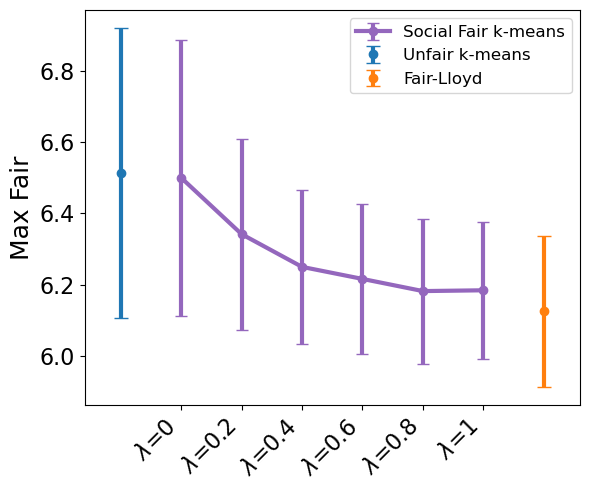

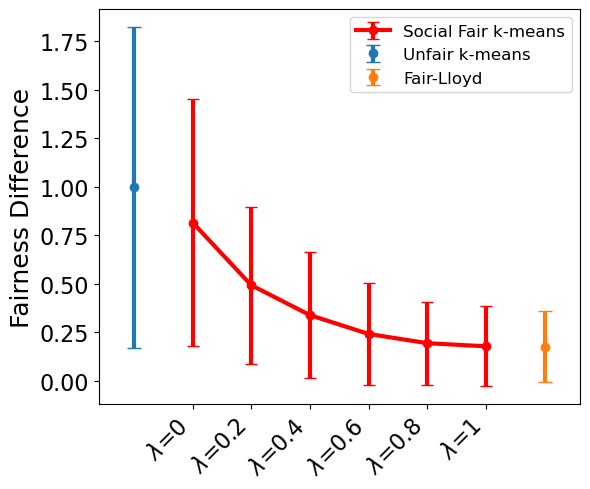

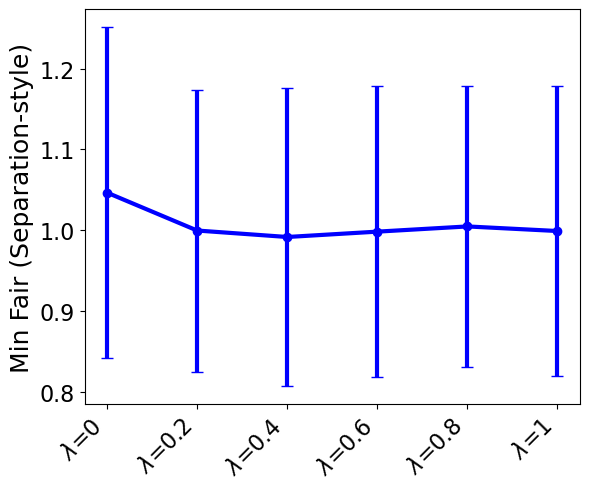

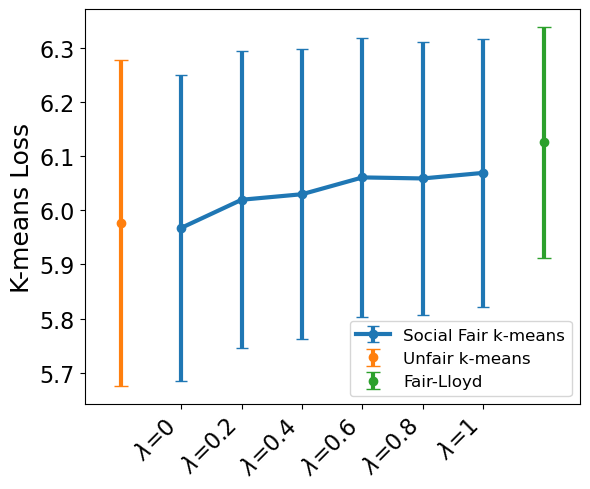

In [17]:
# ------------------------------------------------
# 6. Example usage
# ------------------------------------------------

# Choose one of: "adult", "credit", "bank", "student"
dataset_name = "adult"

metrics_social, cfg_social, lambda_list = run_social_fair_kmeans_pipeline(
    dataset_name,
    lambda2_list=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    seeds=range(10),
    iters_fair=500,
    inner_gd=5,
    lr=0.5,
)

fair_lloyd_stats = load_fair_lloyd_stats(
    cfg_social["tag"], lambda_list, seeds=range(10)
)

plot_social_metrics(
    metrics_social,
    lambda_list,
    cfg_social,
    fair_lloyd_stats=fair_lloyd_stats,
    save_path=f"./plots/{cfg_social['tag']}",
)
